## nb_oro

### En este notebook cargo el dataset del archivo oro para calcular correlaciones entre variables numericas relevantes, ejecutar algun test estadistico y dibujar graficas con matplotlib/seaborn

## Imports

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, spearmanr
from datetime import datetime
from IPython.display import display, HTML

## Parámetros


In [2]:
oro_path = os.path.join(os.curdir, "Data_Lake", "Oro")
nombre_archivo_oro = "oro.parquet"

oro_file_path = os.path.join(oro_path, nombre_archivo_oro)

## Main

### Estilo

In [3]:
plt.style.use('default')
sns.set_palette("husl")
sns.set_theme(style="whitegrid")

pd.set_option("display.max_columns", 200)

### Abrir archivo oro para analizar

In [4]:
analisis_ecommerce_oro_df = pd.read_parquet(oro_file_path)

In [5]:
analisis_ecommerce_oro_df.head()

,order_date_utc,order_year,order_month,order_weekday,order_hour,categoria_metodo_pago,order_value_cents,order_value_net_cents,subtotal_cents,discount_amount_cents,taxes_cents,shipping_cents,refunded_amount_cents,items_count,unique_skus_count,discount_rate,shipping_rate,taxes_rate,refund_rate,basket_diversity_rate
0,2023-07-18 00:00:00+00:00,2023,7,1,18,Otro/Desconocido,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,3,NaN,NaN,NaN,NaN,1.0
1,2023-07-25 00:00:00+00:00,2023,7,1,21,Otro/Desconocido,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,2,NaN,NaN,NaN,NaN,0.5
2,2023-10-04 00:00:00+00:00,2023,10,2,7,Otro/Desconocido,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2,2,NaN,NaN,NaN,NaN,1.0
3,2023-10-04 00:00:00+00:00,2023,10,2,7,Shopify Payments,89900,89900,4000,36000,0,49900,0,1,1,9.0,0.555061,0.0,0.0,1.0
4,2023-10-06 00:00:00+00:00,2023,10,4,15,Otro/Desconocido,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2,2,NaN,NaN,NaN,NaN,1.0


### Comprobaciones de tipos, nulos y clasificacion de columnas

In [6]:
# Tipos de datos
tabla_tipos_de_datos = analisis_ecommerce_oro_df.dtypes.to_frame(name="tipo_dato")
tabla_tipos_de_datos.head(30)

,tipo_dato
order_date_utc,"datetime64[ns, UTC]"
order_year,Int64
order_month,Int64
order_weekday,Int64
order_hour,Int64
categoria_metodo_pago,object
order_value_cents,Int64
order_value_net_cents,Int64
subtotal_cents,Int64
discount_amount_cents,Int64


In [7]:
# Nulos TOP 20
tabla_nulos_top20 = (analisis_ecommerce_oro_df.isna().sum().sort_values(ascending=False).head(20).to_frame(name="conteo_nulos"))
tabla_nulos_top20

,conteo_nulos
subtotal_cents,922
discount_amount_cents,922
order_value_cents,922
order_value_net_cents,922
refund_rate,922
shipping_rate,922
taxes_rate,922
refunded_amount_cents,922
taxes_cents,922
shipping_cents,922


In [8]:
# Clasificación numéricas / categóricas
lista_columnas_numericas = [nombre_columna for nombre_columna in analisis_ecommerce_oro_df.columns if pd.api.types.is_numeric_dtype(analisis_ecommerce_oro_df[nombre_columna])]
lista_columnas_categoricas = [nombre_columna for nombre_columna in analisis_ecommerce_oro_df.columns if nombre_columna not in lista_columnas_numericas]

In [9]:
tabla_resumen_tipos_columnas = pd.DataFrame({"tipo": ["numericas", "categoricas"], "cantidad": [len(lista_columnas_numericas), len(lista_columnas_categoricas)]})

tabla_resumen_tipos_columnas

,tipo,cantidad
0,numericas,18
1,categoricas,2


In [10]:
tabla_muestra_numericas = pd.DataFrame({"columna_numerica": lista_columnas_numericas[:25]})
tabla_muestra_categoricas = pd.DataFrame({"columna_categorica": lista_columnas_categoricas[:25]})
tabla_muestra_numericas, tabla_muestra_categoricas

(         columna_numerica
 0              order_year
 1             order_month
 2           order_weekday
 3              order_hour
 4       order_value_cents
 5   order_value_net_cents
 6          subtotal_cents
 7   discount_amount_cents
 8             taxes_cents
 9          shipping_cents
 10  refunded_amount_cents
 11            items_count
 12      unique_skus_count
 13          discount_rate
 14          shipping_rate
 15             taxes_rate
 16            refund_rate
 17  basket_diversity_rate,
       columna_categorica
 0         order_date_utc
 1  categoria_metodo_pago)

### Descriptivos y frecuencias

In [11]:
# Descriptivos numéricos (limitado a 12 variables para no saturar)
tabla_descriptivos_numericas = (
    analisis_ecommerce_oro_df[lista_columnas_numericas].describe().T.head(12)
    if len(lista_columnas_numericas) > 0
    else pd.DataFrame({"nota": ["No existen columnas numéricas para describir."]})
)

In [12]:
tabla_descriptivos_numericas

,count,mean,std,min,25%,50%,75%,max
order_year,4266.0,2024.561416,0.511167,2023.0,2024.0,2025.0,2025.0,2025.0
order_month,4266.0,6.566338,3.067881,1.0,4.0,7.0,9.0,12.0
order_weekday,4266.0,3.082513,2.074292,0.0,1.0,3.0,5.0,6.0
order_hour,4266.0,14.007736,4.966683,0.0,10.0,14.0,18.0,23.0
order_value_cents,3344.0,432387.828947,139716.361638,63600.0,324300.0,469500.0,482300.0,757800.0
order_value_net_cents,3344.0,432387.828947,139716.361638,63600.0,324300.0,469500.0,482300.0,757800.0
subtotal_cents,3344.0,279954.425837,218822.145332,4000.0,42000.0,284400.0,442400.0,706900.0
discount_amount_cents,3344.0,85204.485646,65682.457344,2000.0,14000.0,93700.0,119175.0,313500.0
taxes_cents,3344.0,59905.023923,39063.964112,0.0,8500.0,79700.0,85500.0,136400.0
shipping_cents,3344.0,42897.159091,5961.840039,29900.0,39900.0,39900.0,49900.0,57500.0


In [13]:
# Frecuencias por categoría de método de pago (si existe)
nombre_columna_categoria_metodo_pago = "categoria_metodo_pago"
tabla_frecuencia_categoria_metodo_pago = (
    analisis_ecommerce_oro_df[nombre_columna_categoria_metodo_pago].value_counts(dropna=False).to_frame(name="frecuencia")
    if nombre_columna_categoria_metodo_pago in analisis_ecommerce_oro_df.columns
    else pd.DataFrame({"nota": ["La columna 'categoria_metodo_pago' no está disponible."]})
)

In [14]:
tabla_frecuencia_categoria_metodo_pago

,frecuencia
categoria_metodo_pago,
Shopify Payments,2452
Otro/Desconocido,922
PayPal,653
Klarna,108
EasyPay,77
MONEI,39
Mixto,15


In [15]:
# Top países de envío
nombre_columna_pais_envio = "shipping_country"
tabla_top_paises_envio = (analisis_ecommerce_oro_df[nombre_columna_pais_envio].value_counts().head(10).to_frame(name="frecuencia")
    if nombre_columna_pais_envio in analisis_ecommerce_oro_df.columns
    else pd.DataFrame({"nota": ["La columna 'shipping_country' no está disponible."]})
)

In [16]:
tabla_top_paises_envio

,nota
0,La columna 'shipping_country' no está disponible.


### Normalizar a euros a partir de *_cents

In [17]:
mapeo_centimos_a_euros = {
    "order_value_cents": "order_value_eur",
    "order_value_net_cents": "order_value_net_eur",
    "subtotal_cents": "subtotal_eur",
    "discount_amount_cents": "discount_amount_eur",
    "taxes_cents": "taxes_eur",
    "shipping_cents": "shipping_eur",
    "refunded_amount_cents": "refunded_amount_eur",
}

In [18]:
for columna_centimos, columna_euros in mapeo_centimos_a_euros.items():
    if columna_centimos in analisis_ecommerce_oro_df.columns:
        analisis_ecommerce_oro_df[columna_euros] = analisis_ecommerce_oro_df[columna_centimos] / 10000.0

### Correlaciones (Pearson y Spearman) + Heatmap (Spearman)

In [19]:
# Uso primero las columnas en euros si existen; si no, paso a *_cents y a *_rate/otras numéricas.
lista_candidatas_preferidas = [
    # Preferidas en euros
    "order_value_eur", "order_value_net_eur", "subtotal_eur",
    "discount_amount_eur", "taxes_eur", "shipping_eur", "refunded_amount_eur",
    # Si no existen en euros, quedarán fuera y luego añadimos sus versiones *_cents:
]

In [20]:
# Añadimos versiones en céntimos (se usarán si no se creo en euros)
lista_candidatas_centimos = [
    "order_value_cents", "order_value_net_cents", "subtotal_cents",
    "discount_amount_cents", "taxes_cents", "shipping_cents", "refunded_amount_cents",
]

In [21]:
# Tasas y otras numéricas relevantes
lista_candidatas_tasas_y_conteos = [
    "items_count", "unique_skus_count",
    "discount_rate", "shipping_rate", "taxes_rate", "refund_rate",
    "basket_diversity_rate"
]

In [22]:
lista_variables_candidatas_correlacion = (lista_candidatas_preferidas + lista_candidatas_centimos + lista_candidatas_tasas_y_conteos)

In [23]:
lista_variables_correlacion_presentes = [
    nombre for nombre in lista_variables_candidatas_correlacion
    if nombre in analisis_ecommerce_oro_df.columns
]

In [24]:
tabla_listado_presentes = pd.DataFrame({"variables_presentes": lista_variables_correlacion_presentes})

In [25]:
tabla_listado_presentes

,variables_presentes
0,order_value_eur
1,order_value_net_eur
2,subtotal_eur
3,discount_amount_eur
4,taxes_eur
5,shipping_eur
6,refunded_amount_eur
7,order_value_cents
8,order_value_net_cents
9,subtotal_cents


In [26]:
condicion_hay_suficientes_variables_correlacion = (len(lista_variables_correlacion_presentes) >= 2)

,order_value_cents,order_value_net_cents,subtotal_cents,discount_amount_cents,taxes_cents,shipping_cents,refunded_amount_cents,items_count,unique_skus_count,discount_rate,shipping_rate,taxes_rate,refund_rate,basket_diversity_rate
order_value_cents,1.000,1.000,0.049,0.219,0.147,0.298,NaN,0.025,NaN,0.233,-0.789,0.028,NaN,-0.025
order_value_net_cents,1.000,1.000,0.049,0.219,0.147,0.298,NaN,0.025,NaN,0.233,-0.789,0.028,NaN,-0.025
subtotal_cents,0.049,0.049,1.000,0.857,0.123,-0.010,NaN,-0.014,NaN,-0.222,0.279,-0.745,NaN,0.014
discount_amount_cents,0.219,0.219,0.857,1.000,0.220,0.021,NaN,-0.016,NaN,0.250,0.185,-0.605,NaN,0.016
taxes_cents,0.147,0.147,0.123,0.220,1.000,-0.122,NaN,-0.018,NaN,0.141,0.085,0.359,NaN,0.018
shipping_cents,0.298,0.298,-0.010,0.021,-0.122,1.000,NaN,0.018,NaN,-0.032,-0.119,-0.014,NaN,-0.018
refunded_amount_cents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items_count,0.025,0.025,-0.014,-0.016,-0.018,0.018,NaN,1.000,0.983,-0.005,-0.011,-0.003,NaN,-0.289
unique_skus_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.983,1.000,NaN,NaN,NaN,NaN,-0.129
discount_rate,0.233,0.233,-0.222,0.250,0.141,-0.032,NaN,-0.005,NaN,1.000,-0.085,0.210,NaN,0.005


,order_value_cents,order_value_net_cents,subtotal_cents,discount_amount_cents,taxes_cents,shipping_cents,refunded_amount_cents,items_count,unique_skus_count,discount_rate,shipping_rate,taxes_rate,refund_rate,basket_diversity_rate
order_value_cents,1.000,1.000,0.404,0.506,0.365,0.255,NaN,0.023,NaN,0.166,-0.900,-0.142,NaN,-0.023
order_value_net_cents,1.000,1.000,0.404,0.506,0.365,0.255,NaN,0.023,NaN,0.166,-0.900,-0.142,NaN,-0.023
subtotal_cents,0.404,0.404,1.000,0.907,0.354,0.097,NaN,-0.004,NaN,-0.590,-0.329,-0.575,NaN,0.004
discount_amount_cents,0.506,0.506,0.907,1.000,0.423,0.137,NaN,-0.006,NaN,-0.327,-0.428,-0.484,NaN,0.006
taxes_cents,0.365,0.365,0.354,0.423,1.000,-0.063,NaN,-0.008,NaN,0.075,-0.358,0.399,NaN,0.008
shipping_cents,0.255,0.255,0.097,0.137,-0.063,1.000,NaN,0.014,NaN,0.115,0.062,-0.227,NaN,-0.014
refunded_amount_cents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
items_count,0.023,0.023,-0.004,-0.006,-0.008,0.014,NaN,1.000,0.998,0.009,-0.011,-0.013,NaN,-0.160
unique_skus_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998,1.000,NaN,NaN,NaN,NaN,-0.117
discount_rate,0.166,0.166,-0.590,-0.327,0.075,0.115,NaN,0.009,NaN,1.000,-0.188,0.506,NaN,-0.009


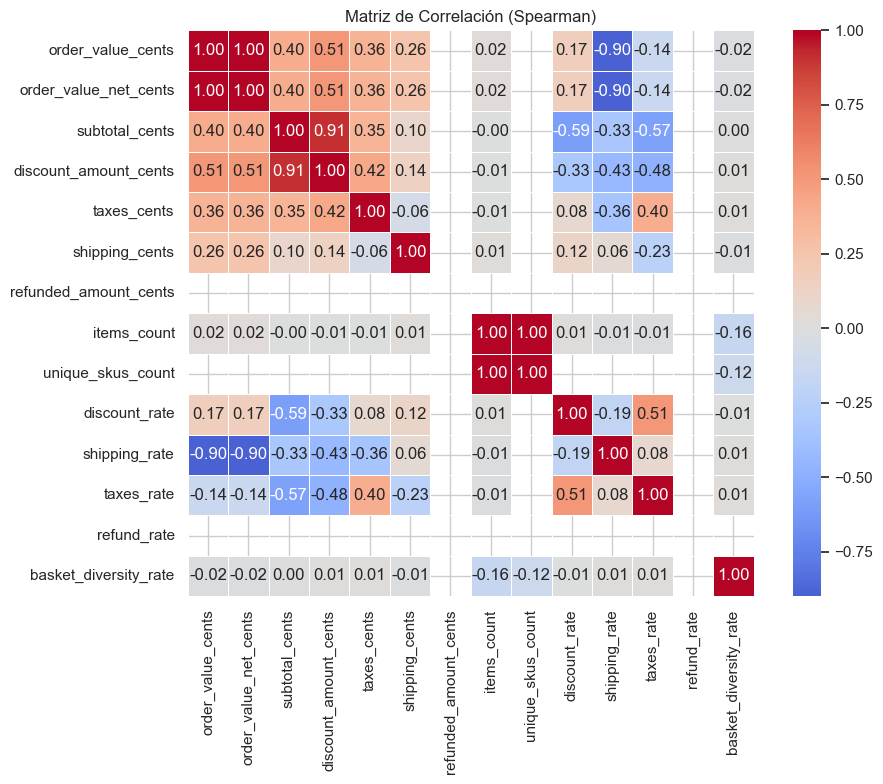

In [27]:
columnas_correlacion = [
    "order_value_cents", "order_value_net_cents", "subtotal_cents",
    "discount_amount_cents", "taxes_cents", "shipping_cents",
    "refunded_amount_cents", "items_count", "unique_skus_count",
    "discount_rate", "shipping_rate", "taxes_rate", "refund_rate",
    "basket_diversity_rate"
]

columnas_presentes = [c for c in columnas_correlacion if c in analisis_ecommerce_oro_df.columns]

# Matrices
matriz_pearson  = analisis_ecommerce_oro_df[columnas_presentes].corr(method="pearson")
matriz_spearman = analisis_ecommerce_oro_df[columnas_presentes].corr(method="spearman")

# Mostrar matrices
from IPython.display import display
display(matriz_pearson.round(3))
display(matriz_spearman.round(3))

# Heatmap Spearman
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_spearman, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidth=0.5)
plt.title("Matriz de Correlación (Spearman)")
plt.tight_layout()
plt.show()

### Tests estadísticos (t-test, ANOVA, Chi-cuadrado)

In [28]:
# Selección de la columna de importe a usar
columna_importe_principal = (
    "order_value_eur" if "order_value_eur" in analisis_ecommerce_oro_df.columns else "order_value_cents"
)

#### t-test

In [29]:
nombre_columna_pagado = "pagado"
if {columna_importe_principal, nombre_columna_pagado}.issubset(analisis_ecommerce_oro_df.columns):
    serie_importe_pagados = (
        analisis_ecommerce_oro_df.loc[analisis_ecommerce_oro_df[nombre_columna_pagado] == 1, columna_importe_principal]
        .dropna()
    )
    serie_importe_no_pagados = (
        analisis_ecommerce_oro_df.loc[analisis_ecommerce_oro_df[nombre_columna_pagado] == 0, columna_importe_principal]
        .dropna()
    )

    if (len(serie_importe_pagados) > 2) and (len(serie_importe_no_pagados) > 2):
        estadistico_t, valor_p_ttest = ttest_ind(serie_importe_pagados, serie_importe_no_pagados)
        pd.DataFrame(
            {"metrica": ["n_pagados", "n_no_pagados", "estadistico_t", "valor_p"],
             "valor": [len(serie_importe_pagados), len(serie_importe_no_pagados), estadistico_t, valor_p_ttest]}
        )
    else:
        pd.DataFrame({"nota": ["t-test omitido: cada grupo debe tener más de 2 observaciones."]})
else:
    pd.DataFrame({"nota": ["t-test omitido: no existe columna binaria 'pagado' en ORO."]})

#### ANOVA

In [30]:
nombre_columna_categoria_metodo_pago = "categoria_metodo_pago"
if {columna_importe_principal, nombre_columna_categoria_metodo_pago}.issubset(analisis_ecommerce_oro_df.columns):
    diccionario_series_por_categoria = {
        categoria: grupo[columna_importe_principal].dropna()
        for categoria, grupo in analisis_ecommerce_oro_df.groupby(nombre_columna_categoria_metodo_pago)
    }
    # Tabla de tamaños por clase (ayuda a ver si hay suficientes observaciones)
    (pd.DataFrame([(k, len(v)) for k, v in diccionario_series_por_categoria.items()],
                  columns=["categoria_metodo_pago", "tamaño_muestra"])
     .sort_values("tamaño_muestra", ascending=False))

    lista_series_validas = [serie for serie in diccionario_series_por_categoria.values() if len(serie) > 2]
    if len(lista_series_validas) >= 3:
        estadistico_f, valor_p_anova = f_oneway(*lista_series_validas)
        pd.DataFrame({"metrica": ["numero_grupos_validos", "estadistico_f", "valor_p"],
                      "valor": [len(lista_series_validas), estadistico_f, valor_p_anova]})
    else:
        pd.DataFrame({"nota": ["ANOVA omitido: se requieren ≥ 3 grupos con n > 2."]})
else:
    pd.DataFrame({"nota": [f"ANOVA omitido: faltan '{columna_importe_principal}' y/o 'categoria_metodo_pago'."]})

#### Chi-cuadrado

In [31]:
if {nombre_columna_categoria_metodo_pago, nombre_columna_pagado}.issubset(analisis_ecommerce_oro_df.columns):
    tabla_contingencia = pd.crosstab(
        analisis_ecommerce_oro_df[nombre_columna_categoria_metodo_pago],
        analisis_ecommerce_oro_df[nombre_columna_pagado],
    )
    tabla_contingencia  # vista de la tabla

    if (tabla_contingencia.shape[0] >= 2) and (tabla_contingencia.shape[1] >= 2):
        chi2, p_valor, grados_libertad, tabla_esperados = chi2_contingency(tabla_contingencia)
        pd.DataFrame({"metrica": ["filas", "columnas", "estadistico_chi2", "valor_p", "grados_libertad"],
                      "valor": [tabla_contingencia.shape[0], tabla_contingencia.shape[1], chi2, p_valor, grados_libertad]})
    else:
        pd.DataFrame({"nota": ["Chi-cuadrado omitido: la tabla necesita al menos tamaño 2×2."]})
else:
    pd.DataFrame({"nota": ["Chi-cuadrado omitido: no existe variable binaria 'pagado' en ORO."]})

### Gráficas usando matplotlib/seaborn

In [32]:
# Elegimos automáticamente las columnas adecuadas (EUR si existen, si no, CENTS)
columna_importe = "order_value_eur" if "order_value_eur" in analisis_ecommerce_oro_df.columns else "order_value_cents"
columna_envio = "shipping_eur" if "shipping_eur" in analisis_ecommerce_oro_df.columns else "shipping_cents"

#### Scatter: Importe vs Envío

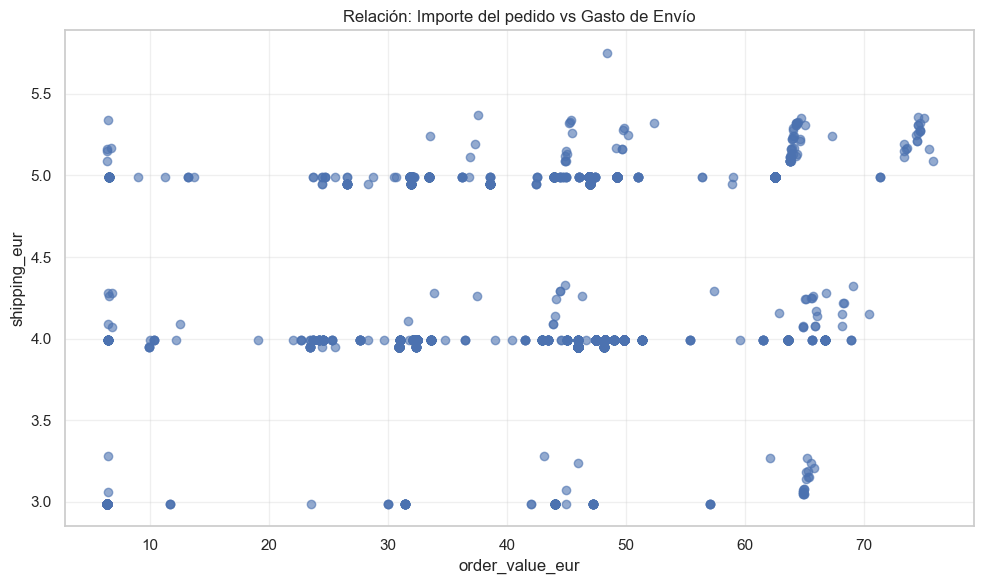

In [33]:
if {columna_importe, columna_envio}.issubset(analisis_ecommerce_oro_df.columns):
    plt.figure(figsize=(10, 6))
    plt.scatter(analisis_ecommerce_oro_df[columna_importe], analisis_ecommerce_oro_df[columna_envio], alpha=0.6)
    plt.title("Relación: Importe del pedido vs Gasto de Envío")
    plt.xlabel(columna_importe)
    plt.ylabel(columna_envio)
    plt.grid(True, alpha=0.3) 
    plt.tight_layout()
    plt.show()
else:
    pd.DataFrame({"nota": ["Scatter omitido: faltan columnas de importe y/o envío."]})

#### Scatter: Items vs Importe


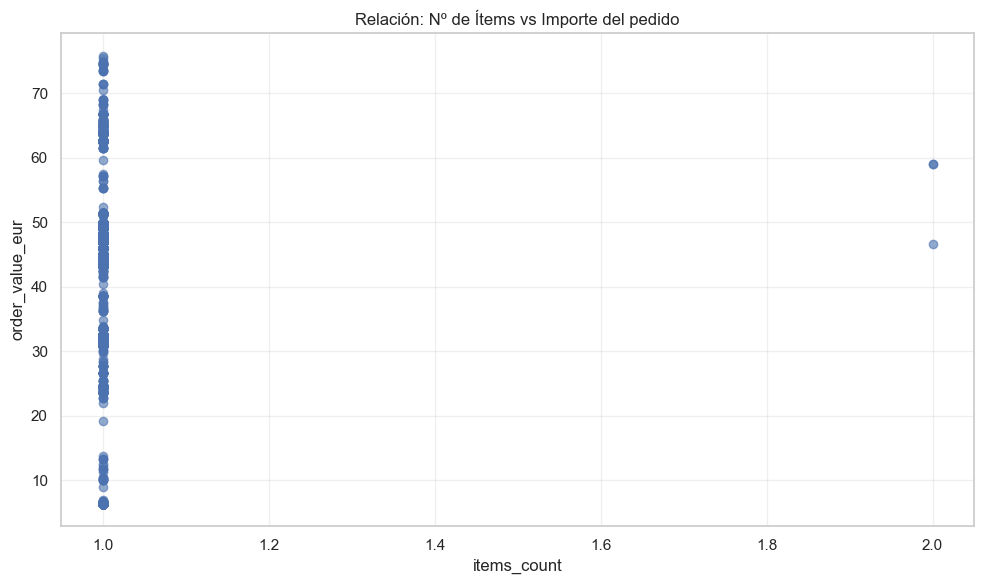

In [34]:
if {"items_count", columna_importe}.issubset(analisis_ecommerce_oro_df.columns):
    plt.figure(figsize=(10, 6))
    plt.scatter(analisis_ecommerce_oro_df["items_count"], analisis_ecommerce_oro_df[columna_importe], alpha=0.6)
    plt.title("Relación: Nº de Ítems vs Importe del pedido")
    plt.xlabel("items_count")
    plt.ylabel(columna_importe)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    pd.DataFrame({"nota": ["Scatter omitido: faltan 'items_count' y/o la columna de importe."]})

#### Boxplot: Importe por método de pago

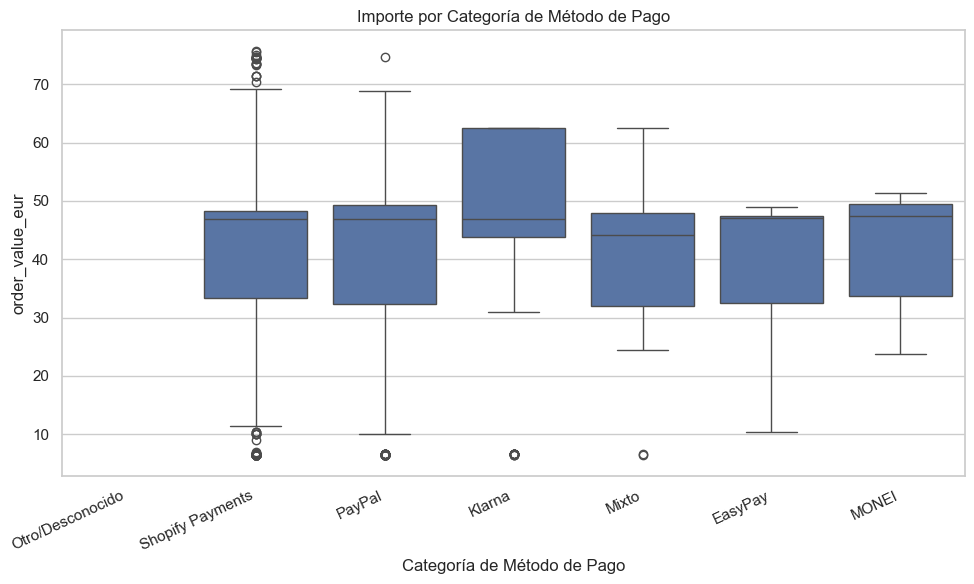

In [35]:
if {"categoria_metodo_pago", columna_importe}.issubset(analisis_ecommerce_oro_df.columns):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=analisis_ecommerce_oro_df, x="categoria_metodo_pago", y=columna_importe)
    plt.title("Importe por Categoría de Método de Pago")
    plt.xlabel("Categoría de Método de Pago")
    plt.ylabel(columna_importe)
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()
else:
    pd.DataFrame({"nota": ["Boxplot omitido: faltan 'categoria_metodo_pago' y/o la columna de importe."]})

#### Histograma: Importe

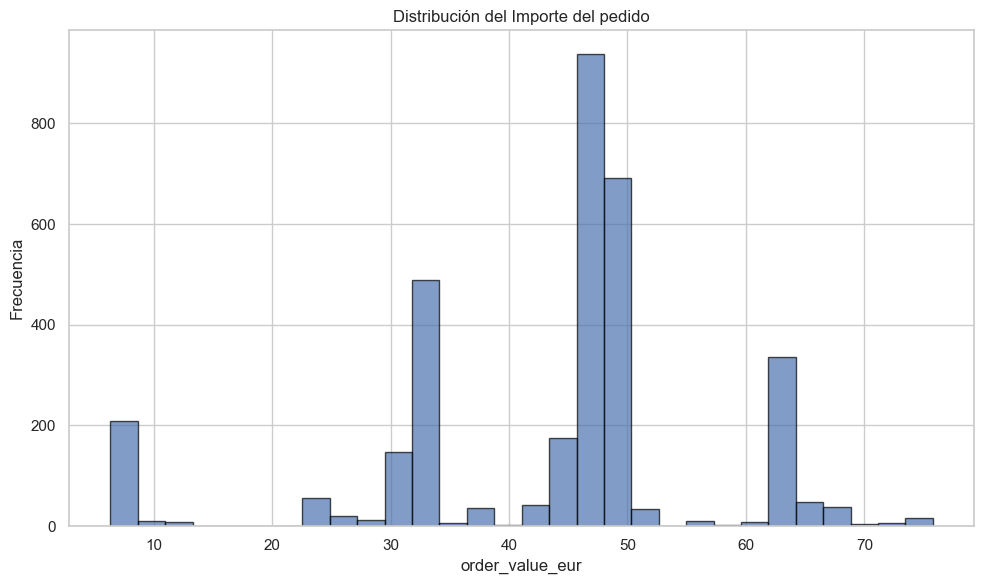

In [36]:
if columna_importe in analisis_ecommerce_oro_df.columns:
    serie_importe = analisis_ecommerce_oro_df[columna_importe].dropna()
    if len(serie_importe) > 0:
        plt.figure(figsize=(10, 6))
        plt.hist(serie_importe, bins=30, alpha=0.7, edgecolor="black")
        plt.title("Distribución del Importe del pedido")
        plt.xlabel(columna_importe)
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()
    else:
        pd.DataFrame({"nota": ["Histograma omitido: la serie de importes está vacía tras eliminar nulos."]})
else:
    pd.DataFrame({"nota": [f"Histograma omitido: no existe columna '{columna_importe}'."]})

#### Serie temporal: Suma diaria de importe por fecha de pedido

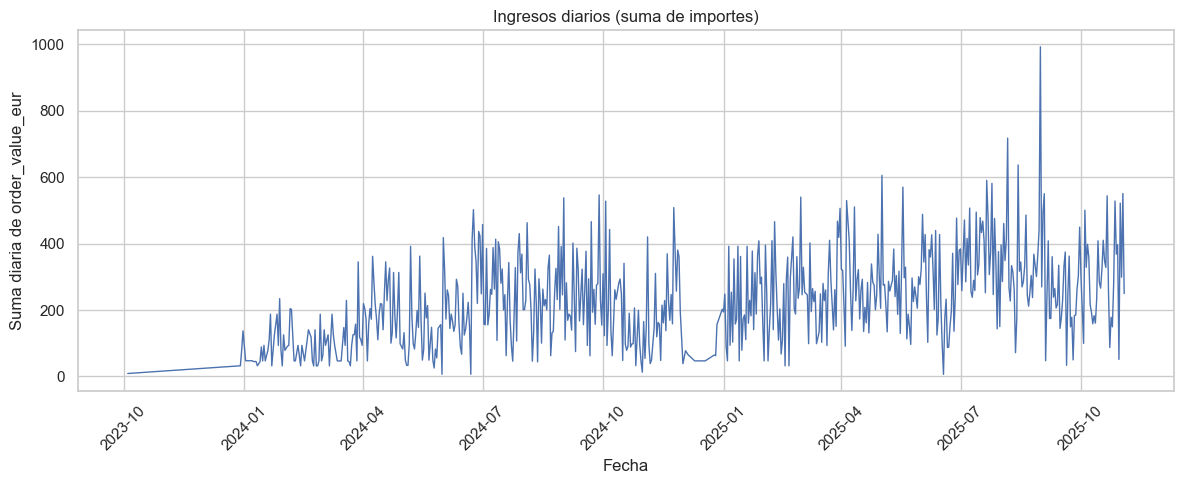

In [37]:
columnas_necesarias = {"order_date_utc", columna_importe}

if columnas_necesarias.issubset(analisis_ecommerce_oro_df.columns):
    # 1) Asegurar que la fecha es datetime
    # 2) Eliminar filas sin fecha o sin importe
    # 3) Crear columna 'fecha' (día) directamente con .dt.date
    dataframe_validas = (
        analisis_ecommerce_oro_df
        .assign(order_date_utc=pd.to_datetime(analisis_ecommerce_oro_df["order_date_utc"], errors="coerce"))
        .dropna(subset=["order_date_utc", columna_importe])
        .assign(fecha=lambda d: d["order_date_utc"].dt.date)
    )
    # 4) Agrupar por 'fecha' y sumar el importe; ordenar por si acaso
    ingresos_diarios = (
        dataframe_validas
        .groupby("fecha", as_index=False)[columna_importe]
        .sum()
        .sort_values("fecha")
    )

    # 5) Graficar si hay datos
    if not ingresos_diarios.empty:
        plt.figure(figsize=(12, 5))
        plt.plot(ingresos_diarios["fecha"], ingresos_diarios[columna_importe], linewidth=1)
        plt.title("Ingresos diarios (suma de importes)")
        plt.xlabel("Fecha")
        plt.ylabel(f"Suma diaria de {columna_importe}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        pd.DataFrame({"nota": ["Serie temporal omitida: no hay días con datos tras limpieza."]})
else:
    pd.DataFrame({"nota": ["Serie temporal omitida: faltan 'order_date_utc' y/o columna de importe."]})